In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms, models
import torch.optim as optim
import os
import random
import cv2
import numpy as np

In [2]:
class_label_real = 0
class_label_attack = 1

OULU-NPU Dataset Protocol I:  
Training -> 1200 (Real 240, Attack 960) \
Validation -> 900 (Real 180, Attack 720) \
Testing -> 600 (Real 120, Attack 480)

OULU-NPU Dataset Protocol II:  
Training -> 1080 (Real 360, Attack 720) \
Validation -> 810 (Real 270, Attack 540) \
Testing -> 1080 (Real 360, Attack 720)

In [3]:
data_path_val_real = '/protocol_I/dev/real'
data_path_val_attack = '/protocol_I/dev/attack'

In [4]:
def load_samples(path, class_label, transform): #Select N frames returned from read_all_frames and assign labels to all samples of same class
        frames = read_all_frames(path)
        total_frames = list(range(0, frames.shape[0], 1))
        selected_samples = 5
        selected_frame = total_frames[selected_samples]
        samples =[]
        # Assign the same class label to all samples
        label = class_label
        samples =(transform(frames[selected_frame].squeeze()), label)     
        return samples

def read_all_frames(video_path): # reads all frames from a particular video and converts them to PyTorch tensors.
    frame_list = []
    video = cv2.VideoCapture(video_path)
    success = True
    while success:
        success, frame = video.read()
        if success:
            frame = cv2.resize(frame, (256, 256), interpolation=cv2.INTER_AREA) #framesize kept 256 x 256 
            frame_list.append(frame)
    frame_list = np.array(frame_list)
    return frame_list

class VideoDataset(Dataset):
    def __init__(self, data_path, class_label):
        self.data_path = data_path #path for directory containing video files
        self.video_files = [file for file in os.listdir(data_path) if file.endswith('.avi')]
        self.class_label = class_label #manually assign class_label for your desired class while loading
        self.data_length = len(self.video_files) 
        self.transform = transforms.Compose([transforms.ToTensor()])

    def __len__(self): # returns the total number of samples in the dataset
        return self.data_length

    def __getitem__(self, idx): # loads and returns a sample from the dataset at the given index
        file = self.video_files[idx]
        path = os.path.join(self.data_path, file)
        frames= load_samples(path, self.class_label, self.transform)

        return frames

In [5]:

val_dataset_real = VideoDataset(data_path_val_real, class_label_real)
val_dataset_attack = VideoDataset(data_path_val_attack, class_label_attack)

In [6]:
concatenated_val_dataset = ConcatDataset([val_dataset_real, val_dataset_attack])
concatenated_val_loader = DataLoader(concatenated_val_dataset, batch_size=64, shuffle=False, pin_memory=True, num_workers=8)

In [7]:
# Print dataset sizes
print(f"Test set size: {len(concatenated_val_dataset)}")

Test set size: 900


In [8]:
# Load pre-trained MobileNetV2
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(in_features=1280, out_features=2) #default in_features =1280, out_features = 1000
# print(model)

/home/taha/anaconda3/envs/pt_fpad/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/taha/anaconda3/envs/pt_fpad/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the path to your saved model file
model_path = '/OULUprotocols/protocol_I/OULUNPU_prot_I.pth' # before OULU_prot_I.pth after OULU_prot_I_FB.pth before OULU_prot_II.pth after OULU_prot_II_FB.pth 

# Load the saved model
checkpoint = torch.load(model_path)

# Load the model's state dictionary
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [10]:
# Evaluate on the validation set
val_correct = 0
val_total = 0

model.eval()
with torch.no_grad():
    
    val_cat_labels = torch.empty(0, dtype=torch.int64, device=device)
    val_predicted_cat_labels = torch.empty(0, dtype=torch.int64, device=device)
    val_model_op_cat = torch.empty(0, dtype=torch.int64, device=device)

    for val_images, val_labels in concatenated_val_loader:
        val_images, val_labels = val_images.to(device), val_labels.to(device)
        val_model_op = model(val_images)
        _, val_predicted = torch.max(val_model_op, 1)
        val_correct += (val_predicted == val_labels).sum().item() 
        val_total += val_labels.size(0)

        val_cat_labels = torch.cat((val_cat_labels, val_labels))
        val_predicted_cat_labels = torch.cat((val_predicted_cat_labels, val_predicted))
        val_model_op_cat = torch.cat((val_model_op_cat, val_model_op))

    val_accuracy = val_correct / val_total * 100  
    print(f'Test Accuracy: {val_accuracy:.2f}%')

Test Accuracy: 99.67%


In [ ]:
import torch.nn.functional as F

softmax_output = F.softmax(val_model_op_cat, dim=1)

val_model_op_cat_second_column = softmax_output[:, 1]

val_cat_labels_cpu = val_cat_labels.cpu()

val_model_op_cat_second_column_cpu = val_model_op_cat_second_column.cpu()

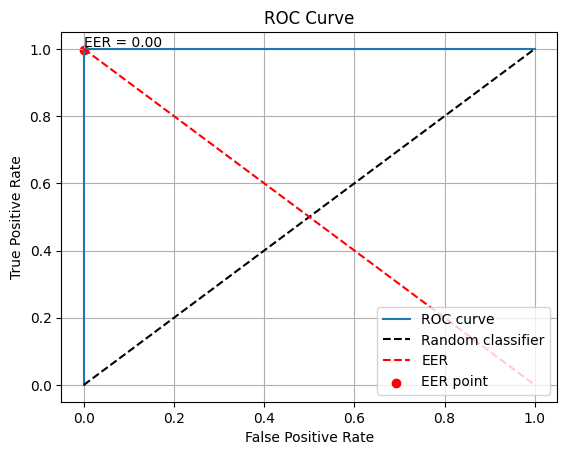

EER: 0.0, Threshold: 0.5868009924888611


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(val_cat_labels_cpu, val_model_op_cat_second_column_cpu)

# Calculate the FNR (false negative rate)
fnr = 1 - tpr

# Find the point where FPR and FNR are closest to each other
eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]

# Calculate the EER
eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')  # Diagonal line
plt.plot([0, 1], [1, 0], 'r--', label='EER')  # Diagonal line added by Sir Shujaat
plt.scatter(fpr[np.nanargmin(np.absolute((fnr - fpr)))], tpr[np.nanargmin(np.absolute((fnr - fpr)))], marker='o', color='red', label='EER point')
plt.text(fpr[np.nanargmin(np.absolute((fnr - fpr)))], tpr[np.nanargmin(np.absolute((fnr - fpr)))], f'EER = {eer:.2f}', verticalalignment='bottom')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

print(f"EER: {eer}, Threshold: {eer_threshold}")
